In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import pickle


from embo import EmpiricalBottleneck
import dit
from dit.rate_distortion import IBCurve

plt.style.use('style.mplstyle')

The generalized IB codebase was largely underdocumented, all contained in a single Python file about 1400 lines long (by comparison, the two files that make up the core of embo, excluding tests and packaging files, sum up to less than 400 lines, and that's including a copyright notice in each file). There was no obvious way of running the algorithm for a probability distribution rather than an empirical sample. There were two examples but no indications of what they were supposed to be examples of. I tried running one: it took a very long time to run (on the order of an hour) and at the end I got a printout of some very large pandas dataframes, which I am unsure how to interpret. I gave up.

In [2]:
palette = [item['color'] for item in plt.rcParams['axes.prop_cycle']]

colors = {
    'embo' : palette[2],
    'dit/sp' : palette[1],
    'dit/ba' : palette[3]
}

tool_names = list(colors.keys())

In [3]:
# set up the same probability distributions in two different formats, one embo-friendly, the other dit-friendly
dist = {
    'embo' : [
        np.array([
            [0.1, 0.4],
            [0.35, 0.15]]),
        np.array([
            [0.2, 0, 0.2],
            [0, 0, 0.2],
            [0, 0.2, 0.2]]),
        np.array([
            [0.1, 0.1, 0, 0.1],
            [0.05, 0, 0.05, 0.1],
            [0.02, 0.03, 0.25, 0.1],
            [0.03, 0.02, 0., 0.05]]),
        np.array([
            [0.03, 0.07, 0, 0.1, 0.1],
            [0.025, 0, 0.05, 0.1, 0],
            [0.02, 0, 0.05, 0.05, 0.05],
            [0.01, 0.02, 0., 0.05, 0.02],
            [0.025, 0.03, 0.1, 0.1, 0]])
]}
dist['dit'] = [dit.Distribution.from_ndarray(d) for d in dist['embo']]

# set up common configurations for the algorithms
numbeta = 101
maxbeta = 10

In [4]:
# prepare data format for uniform access
results = {
    tool : {
        'ix' : [],
        'iy' : [],
        'beta' : [],
        'ixy' : [],
        'hx' : [],
        'time' : [],
        'dimensionality' : []
    } for tool in tool_names
}

In [5]:
# Run bottleneck with Embo
for k, d in enumerate(dist['embo']):
    t = %timeit -o -r1 eb = EmpiricalBottleneck(pxy=d, numbeta=numbeta, maxbeta=maxbeta, processes=1);\
    eb.get_empirical_bottleneck(return_entropies=True);\
    results['embo']['ix'].append(eb.i_x);\
    results['embo']['iy'].append(eb.i_y);\
    results['embo']['beta'].append(eb.beta);\
    results['embo']['ixy'].append(eb.mixy);\
    results['embo']['hx'].append(eb.hx)
    results['embo']['time'].append(t)
    results['embo']['dimensionality'].append(d.size)

213 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
265 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
329 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
366 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
# Run bottleneck with dit
for method in ['sp', 'ba']:
    tool = f"dit/{method}"
    print(f"===={tool}====")
    for k, d in enumerate(dist['dit']):
        try:
            t = %timeit -o -r1 ib = IBCurve(d, method=method, beta_num=numbeta, beta_max=maxbeta);\
            results[tool]['ix'].append(ib.complexities);\
            results[tool]['iy'].append(ib.relevances);\
            results[tool]['beta'].append(ib.betas);\
            results[tool]['ixy'].append(ib._max_relevance);\
            results[tool]['hx'].append(ib._max_complexity)
            results[tool]['time'].append(t)
            results[tool]['dimensionality'].append(dist['embo'][k].size)
        except:
            print(f"Dit crashed with {method} method for distribution n.{k}")
            results[tool]['ix'].append(None)
            results[tool]['iy'].append(None)
            results[tool]['beta'].append(None)
            results[tool]['ixy'].append(None)
            results[tool]['hx'].append(None)
            results[tool]['time'].append(np.NaN)
            results[tool]['dimensionality'].append(dist['embo'][k].size)

====dit/sp====
11.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
26.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4min 4s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5min 46s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
====dit/ba====
Dit crashed with ba method for distribution n.0
13min 50s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
20min 20s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
30min 28s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
with open('embo_vs_dit_results.pickle', 'wb') as f:
    pickle.dump(results, f)

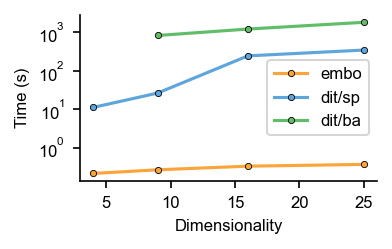

In [9]:
fig, ax = plt.subplots()
for tool in tool_names:
    res = results[tool]
    time = np.array([t if t is np.NaN else t.average for t in res['time']])
    dimensionality = np.array(res['dimensionality'])
    ax.semilogy(dimensionality, time, label=tool, marker='.', color=colors[tool])
ax.set_xlabel('Dimensionality')
ax.set_ylabel('Time (s)')
ax.set_yticks([1, 10, 100, 1000])
ax.tick_params(axis='y', which='minor', left=True)
ax.legend()
plt.show()
fig.savefig('embo_vs_dit_timing.png')

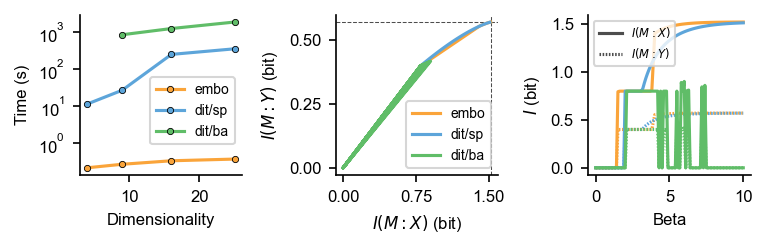

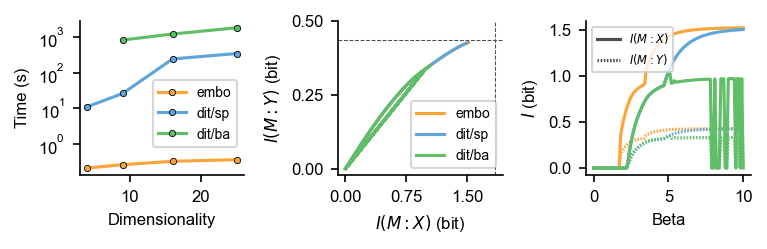

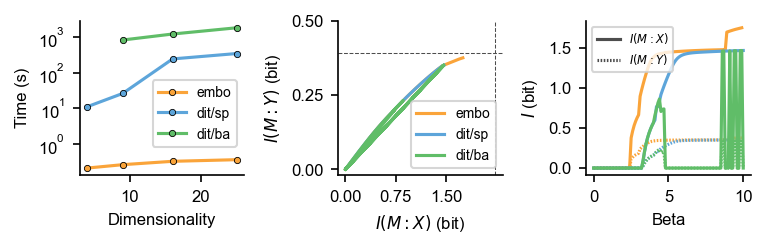

In [22]:
for dist_number in [1,2,3]:

    fig, ax = plt.subplots(nrows=1,ncols=3, figsize=np.array((2,1))*plt.rcParams['figure.figsize'], constrained_layout=True)
    legend_loc = 'upper left'
    n_dists_per_setting = int(len(results['embo']['hx'])/4)
    dist_n_absolute = dist_number*n_dists_per_setting
    dist_offset = {'embo' : 0, 'dit/sp' : 0, 'dit/ba' : -(n_dists_per_setting-1)}


    for tool in tool_names:
        dist_n = dist_n_absolute + dist_offset[tool]
        res = results[tool]
        color = colors[tool]
        a = ax[1]
        a.plot(res['ix'][dist_n], res['iy'][dist_n], label=tool, color=color)
        a.legend(loc='lower right', fontsize='small')
        a.set_ylabel("$I(M:Y)$ (bit)")
        a.set_xlabel("$I(M:X)$ (bit)")
        if tool=='embo':
            a.axhline(res['ixy'][dist_n], linestyle='--', linewidth=0.5, color=palette[0], zorder=-5)
            a.axvline(res['hx'][dist_n], linestyle='--', linewidth=0.5, color=palette[0], zorder=-5)
        a.set_xticks([0, 0.75, 1.5])
        a.set_yticks([0., 0.25, 0.5])

        a = ax[2]
        a.plot(res['beta'][dist_n], res['ix'][dist_n], label=tool, color=color)
        a.set_ylabel("$I$ (bit)")
        a.set_xlabel("Beta")

        a = ax[2]
        a.plot(res['beta'][dist_n], res['iy'][dist_n], label=tool, color=color, linestyle=(0,(0.5,0.5)))
        a.set_xlabel("Beta")

    custom_lines = [
        Line2D([0], [0], color=palette[0], linestyle="-"),
        Line2D([0], [0], color=palette[0], linestyle=(0,(0.5,0.5)))
    ]
    ax[2].legend(custom_lines, ["$I(M:X)$", "$I(M:Y)$"], fontsize='x-small', ncol=1, loc='upper left')

    a = ax[0]
    for tool in tool_names:
        res = results[tool]
        time = np.array([t if t is np.NaN else t.average for t in res['time']])
        dimensionality = np.array(res['dimensionality'])
        a.semilogy(dimensionality, time, label=tool, marker='.', color=colors[tool])
    a.set_xlabel('Dimensionality')
    a.set_ylabel('Time (s)')
    a.set_yticks([1, 10, 100, 1000])
    a.legend(loc='center right', bbox_to_anchor=(1, 0.4), fontsize='small')
    plt.show()

    fig.savefig(f'embo_vs_dit_dist{dist_number}.png')